In [29]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [6]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '../dataset/UCI_HAR_Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '../dataset/UCI_HAR_Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [7]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [9]:
# 특성 분포를 시각화하는 보조 함수
def plot_distributions(trainX):
    # 중복 부분을 제거합니다.
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # 시계열 데이터를 2D 배열로 변환합니다.
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    print(longX.shape)
    # 새로운 그림을 생성합니다.
    pyplot.figure()
    xaxis = None
    # 각 특성에 대한 루프를 실행합니다.
    for i in range(longX.shape[1]):
        # 현재 특성에 대한 하위 플롯을 생성합니다.
        ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
        # x 축의 범위를 설정합니다.
        ax.set_xlim(-1, 1)
        # 첫 번째 특성인 경우 x 축을 설정합니다.
        if i == 0:
            xaxis = ax
        # 현재 특성의 히스토그램을 그립니다.
        pyplot.hist(longX[:, i], bins=100)
    # 그림을 화면에 출력합니다.
    pyplot.show()


(470528, 9)


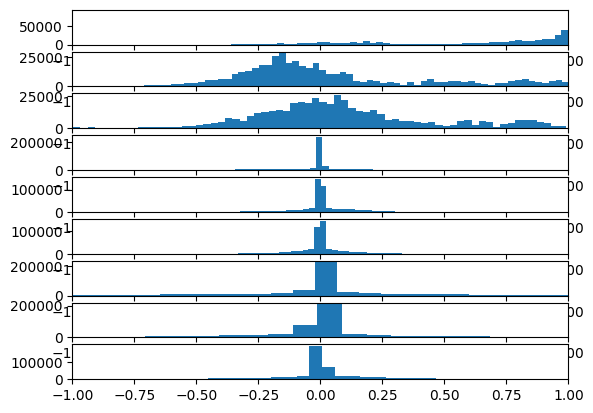

In [10]:
# 특성 분포 시각화를 위한 함수 호출
plot_distributions(trainX)

In [11]:
batch_size = 64 # 미니배치 크기 설정
validation_split = 0.2 # 검증 데이터 비율 설정 (20%는 검증 데이터로 사용)

# CNN + LSTM

In [12]:
# 모델 입력 변수 설정
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()# Sequential 모델 생성
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps, n_features))) # 1D 합성곱 레이어 추가, 입력 형태: (시간 스텝, 특성)
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps, n_features))) # 또 다른 1D 합성곱 레이어 추가, 입력 형태: (시간 스텝, 특성)
model.add(Dropout(0.5)) # 드롭아웃 레이어 추가 (드롭아웃 비율: 0.5)
model.add(MaxPooling1D(pool_size=2)) # 1D 맥스 풀링 레이어 추가 (풀링 크기 2)
model.add(LSTM(64, recurrent_dropout=0.5)) # LSTM 레이어 추가 (64개의 유닛, 순환 드롭아웃 비율: 0.5)
model.add(Dropout(0.5)) # 드롭아웃 레이어 추가 (드롭아웃 비율: 0.5)
model.add(Dense(n_outputs, activation='softmax')) # 출력 레이어 추가 (출력 개수: n_outputs, 활성화 함수: softmax)


model.summary() # 모델 구조 요약 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 125, 64)           2368      
                                                                 
 conv1d_1 (Conv1D)           (None, 122, 64)           16448     
                                                                 
 dropout (Dropout)           (None, 122, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 61, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# 네트워크를 훈련

train_epochs = 20
history = model.fit( # 모델을 훈련하고 히스토리 정보를 저장
    trainX,           # 훈련 데이터
    trainy,           # 훈련 데이터의 레이블
    epochs=train_epochs,  # 에포크 수
    batch_size=batch_size,  # 미니배치 크기
    verbose=True,          # 훈련 과정을 출력
    validation_split=validation_split,  # 검증 데이터 비율
    shuffle=True           # 데이터를 무작위로 셔플
)

Epoch 1/20
92/92 [==============================] - 9s 77ms/step - loss: 0.8797 - accuracy: 0.6320 - val_loss: 0.4813 - val_accuracy: 0.8613
Epoch 2/20
92/92 [==============================] - 6s 66ms/step - loss: 0.3823 - accuracy: 0.8658 - val_loss: 0.4198 - val_accuracy: 0.8613
Epoch 3/20
92/92 [==============================] - 6s 65ms/step - loss: 0.2463 - accuracy: 0.9194 - val_loss: 0.3952 - val_accuracy: 0.8783
Epoch 4/20
92/92 [==============================] - 6s 67ms/step - loss: 0.1808 - accuracy: 0.9362 - val_loss: 0.3278 - val_accuracy: 0.9041
Epoch 5/20
92/92 [==============================] - 6s 63ms/step - loss: 0.1677 - accuracy: 0.9401 - val_loss: 0.3553 - val_accuracy: 0.9055
Epoch 6/20
92/92 [==============================] - 6s 63ms/step - loss: 0.1408 - accuracy: 0.9478 - val_loss: 0.3304 - val_accuracy: 0.8885
Epoch 7/20
92/92 [==============================] - 6s 64ms/step - loss: 0.1237 - accuracy: 0.9495 - val_loss: 0.3273 - val_accuracy: 0.9123
Epoch 8/20
92

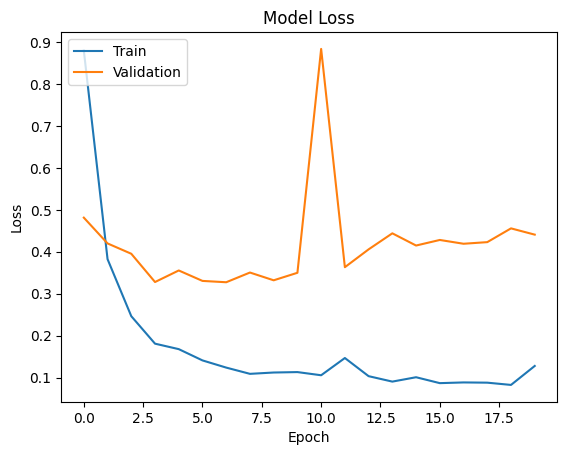

In [15]:
# 훈련 및 검증 손실을 시각화
plt.plot(history.history['loss'], label='Train Loss') # 훈련 손실(train loss)을 그래프에 추가
plt.plot(history.history['val_loss'], label='Validation Loss') # 검증 손실(validation loss)을 그래프에 추가
plt.title('Model Loss') # 그래프 제목 설정
plt.ylabel('Loss') # y 축 레이블 설정
plt.xlabel('Epoch') # x 축 레이블 설정
plt.legend(['Train', 'Validation'], loc='upper left') # 범례(legend) 추가 (훈련 손실과 검증 손실에 대한 레이블 표시)
plt.show() # 그래프를 화면에 출력

In [16]:
# 모델 평가

# 테스트 손실(test loss)과 테스트 정확도(test accuracy)를 계산
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model:", test_accuracy) # 모델의 정확도를 출력
predictions = model.predict(testX) # 모델을 사용하여 테스트 데이터에 대한 예측을 수행

Accuracy of the CNN model: 0.8998982310295105
93/93 [==============================] - 1s 8ms/step


In [17]:
predictions

array([[4.63568213e-05, 8.47387710e-05, 1.65740530e-05, 7.85609242e-04,
        9.99054492e-01, 1.22572865e-05],
       [4.73407745e-05, 8.47892734e-05, 1.66839473e-05, 7.89198442e-04,
        9.99049485e-01, 1.24979288e-05],
       [4.70005252e-05, 8.34639359e-05, 1.63249424e-05, 7.71103369e-04,
        9.99069870e-01, 1.22369547e-05],
       ...,
       [2.69317592e-04, 9.99322653e-01, 1.89388869e-04, 5.36887637e-06,
        1.20771438e-04, 9.25178174e-05],
       [1.21484080e-03, 9.97513175e-01, 6.03332010e-04, 3.50549635e-05,
        4.02989652e-04, 2.30583653e-04],
       [4.00715595e-04, 9.99172330e-01, 1.97528250e-04, 7.09914821e-06,
        1.24927625e-04, 9.73130300e-05]], dtype=float32)

In [18]:
# 분류 결과 시각화 및 출력 함수 정의

def display_results(testy, predictions, classNames):
    # 정답 레이블과 모델의 예측 결과를 각각의 클래스 인덱스로 변환
    y_test = np.argmax(testy, axis=1)
    y_scores = np.argmax(predictions, axis=1)
    classes = len(classNames) # 클래스의 개수를 계산
    cm = confusion_matrix(y_test, y_scores) # 혼동 행렬을 계산
    
    # 혼동 행렬 출력
    print("**** Confusion Matrix ****")
    print(cm)
    
    # 분류 보고서 출력
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    
    # 혼동 행렬 시각화
    con = np.zeros((classes, classes))
    for x in range(classes):
        for y in range(classes):
            con[x, y] = cm[x, y]  # 혼동 행렬의 값
    
    plt.figure(figsize=(10, 8))
    
    # seaborn을 사용하여 혼동 행렬을 열람합니다.
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues', xticklabels=classNames, yticklabels=classNames)
    plt.xlabel('Predicted')  # x 축 레이블
    plt.ylabel('Actual')  # y 축 레이블
    plt.show() # 그래프를 화면에 출력


**** Confusion Matrix ****
[[489   5   2   0   0   0]
 [  4 445  22   0   0   0]
 [ 16  19 385   0   0   0]
 [  0  25   0 410  56   0]
 [  0   2   0 101 429   0]
 [  0  43   0   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.96      0.99      0.97       496
           2       0.83      0.94      0.88       471
           3       0.94      0.92      0.93       420
           4       0.80      0.84      0.82       491
           5       0.88      0.81      0.84       532
           6       1.00      0.92      0.96       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



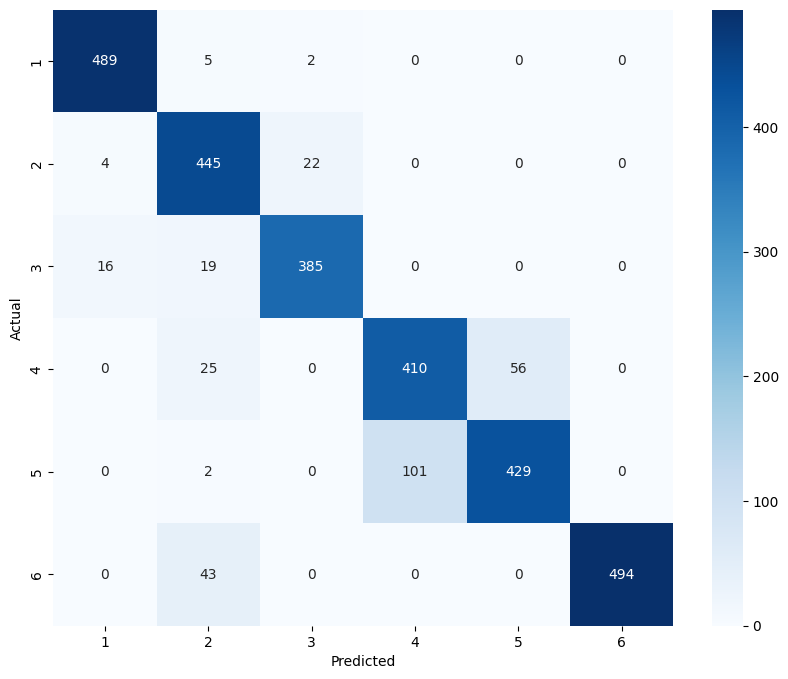

In [20]:
classNames = ["1", "2", "3", "4", "5", "6"] # classNames = 레이블
display_results(testy, predictions, classNames) # 분류 결과를 시각화, 출력

# CNN

In [32]:
# 모델 구조 정의

# 입력 데이터의 크기를 기반으로 입력 형태를 설정합니다.
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential() # Sequential 모델 생성

# 1D-CNN 추가
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps, n_features)))

# 또 다른 1D-CNN 추가
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5)) # 드롭아웃 레이어를 추가(드롭아웃 비율 0.5)
model.add(MaxPooling1D(pool_size=2)) # 맥스 풀링 레이어를 추가 (풀링 크기 2)
model.add(Flatten()) # 1D-CNN 출력을 Flatten
model.add(Dense(100, activation='relu')) # 완전 연결(Dense) 레이어를 추가합니다. (뉴런 수 100, 활성화 함수 'relu')
model.add(Dense(n_outputs, activation='softmax')) # 출력 레이어 추가 (클래스 수에 해당하는 뉴런 수, 활성화 함수 'softmax')
plot_model(model, show_shapes=True, show_layer_names=True) # 모델 구조를 시각화 (레이어의 형태와 이름을 표시)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
# 모델 학습 설정 및 실행
train_epochs = 20

# Model train
history = model.fit(
    trainX,                 # 학습 데이터 (입력)
    trainy,                 # 학습 데이터 (타겟)
    epochs=train_epochs,    # 학습 에포크 수
    batch_size=batch_size,  # 배치 크기
    verbose=True,           # 학습 과정 로그 출력 여부 (True로 설정하면 학습 진행 상황이 출력됨)
    validation_split=validation_split,  # 검증 데이터를 위한 분할 비율
    shuffle=True            # 데이터를 섞을지 여부 (True로 설정하면 에포크마다 데이터가 섞임)
)

Epoch 1/20
92/92 [==============================] - 3s 24ms/step - loss: 0.4707 - accuracy: 0.8113 - val_loss: 0.3679 - val_accuracy: 0.9014
Epoch 2/20
92/92 [==============================] - 2s 23ms/step - loss: 0.1441 - accuracy: 0.9413 - val_loss: 0.3141 - val_accuracy: 0.9062
Epoch 3/20
92/92 [==============================] - 2s 23ms/step - loss: 0.1073 - accuracy: 0.9543 - val_loss: 0.2991 - val_accuracy: 0.9116
Epoch 4/20
92/92 [==============================] - 2s 22ms/step - loss: 0.0909 - accuracy: 0.9607 - val_loss: 0.3298 - val_accuracy: 0.9062
Epoch 5/20
92/92 [==============================] - 2s 22ms/step - loss: 0.0850 - accuracy: 0.9628 - val_loss: 0.3581 - val_accuracy: 0.9171
Epoch 6/20
92/92 [==============================] - 2s 22ms/step - loss: 0.0996 - accuracy: 0.9572 - val_loss: 0.3672 - val_accuracy: 0.9062
Epoch 7/20
92/92 [==============================] - 2s 23ms/step - loss: 0.0791 - accuracy: 0.9623 - val_loss: 0.3875 - val_accuracy: 0.9075
Epoch 8/20
92

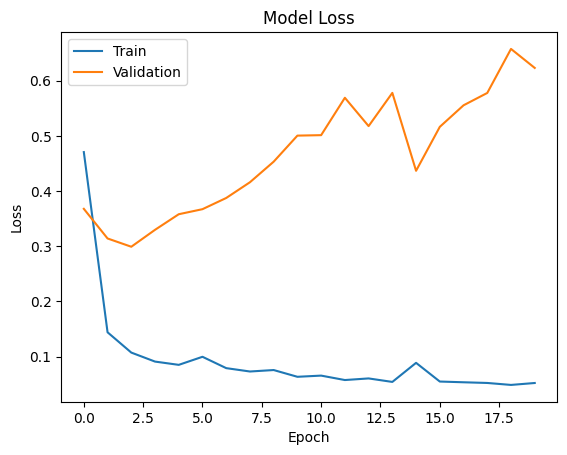

In [35]:
# 학습 손실 시각화

# 학습 과정에서 기록한 훈련 손실과 검증 손실 데이터를 시각화합니다.
plt.plot(history.history['loss'], label='Training Loss')        # 훈련 손실
plt.plot(history.history['val_loss'], label='Validation Loss')  # 검증 손실

# 그래프 제목과 레이블 설정
plt.title('Model Loss')  # 그래프 제목
plt.xlabel('Epoch')      # x축 레이블 (에포크)
plt.ylabel('Loss')       # y축 레이블 (손실)

# 범례(legend) 표시 (훈련 손실과 검증 손실에 대한 범례)
plt.legend(['Train', 'Validation'], loc='upper left')

# 그래프를 표시합니다.
plt.show()

In [36]:
# 모델 평가

# 모델을 테스트 데이터로 평가하여 손실과 정확도를 얻습니다.
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model:", test_accuracy)
predictions = model.predict(testX) # 모델을 사용하여 테스트 데이터에 대한 예측 수행

Accuracy of the CNN model: 0.9131320118904114
93/93 [==============================] - 0s 3ms/step


**** Confusion Matrix ****
[[472   0  24   0   0   0]
 [ 19 426  26   0   0   0]
 [  1   0 419   0   0   0]
 [  0   1   0 432  52   6]
 [  0   0   0 111 421   0]
 [  0  16   0   0   0 521]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.96      0.95      0.96       496
           2       0.96      0.90      0.93       471
           3       0.89      1.00      0.94       420
           4       0.80      0.88      0.84       491
           5       0.89      0.79      0.84       532
           6       0.99      0.97      0.98       537

    accuracy                           0.91      2947
   macro avg       0.91      0.92      0.91      2947
weighted avg       0.92      0.91      0.91      2947



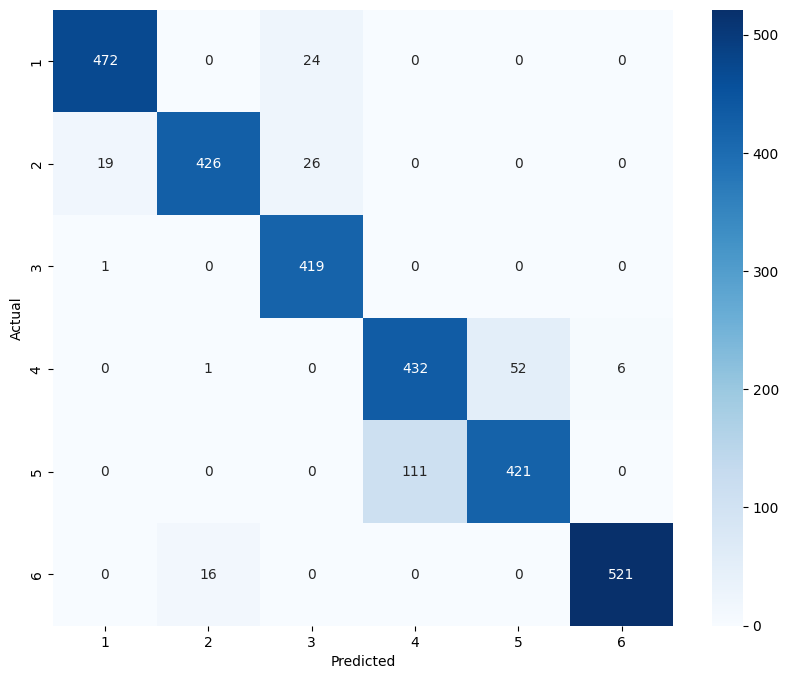

In [42]:
display_results(testy,predictions,classNames)

In [40]:
sample = testX[0] # 첫 번째 테스트 데이터 샘플을 선택
sample.shape # 선택한 샘플의 모양(차원)을 확인

(128, 9)

In [41]:
# 모델을 사용하여 결과 예측을 수행

# 예측을 수행할 샘플을 모델에 입력하기 위해 형태를 조정합니다.
# 모델은 입력 형태가 (numberOfSamples, featureLength, numberOfFeatures)인 형태를 요구합니다.
# 따라서 선택한 샘플을 (1, sample.shape[0], sample.shape[1]) 형태로 변환합니다.
sample_reshaped = sample.reshape(1, sample.shape[0], sample.shape[1])

# 모델을 사용하여 샘플에 대한 예측을 수행합니다.
predictionForSample = model.predict(sample_reshaped)

1/1 [==============================] - 0s 16ms/step


In [43]:
# 선택한 샘플에 대한 예측 클래스와 실제 클래스를 비교하여 출력

# 모델을 사용하여 예측한 클래스를 얻습니다. (가장 확률이 높은 클래스)
samplePredictedClass = np.argmax(predictionForSample, axis=1)

# 실제 클래스를 얻습니다. (원핫 인코딩된 형태에서 가장 높은 값의 인덱스를 선택)
sampleActualClass = np.argmax(testy, axis=1)

# 선택한 샘플의 실제 클래스와 예측 클래스 출력
print("Actual class:", sampleActualClass[0])      # 실제 클래스
print("Predicted class:", samplePredictedClass[0])  # 예측 클래스

Actual class: 4
Predicted class: 4
